# Imports

In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1.1.1. Получение первичных данных из: АСУПР, ЕДЦ, КГХ, МЖИ, Наш город, ЭВАДЖ (перечень предоставляемой информации из Приложения)

Данные:
- в 5 приложении есть все источники кроме ЭВАДЖ;
- в таблицах много событий, не относящихся к теплоснабжению, их надо фильтровать;

Выводы:
- Представлено только 12 типов нужных событий в данных, появляются неравномерно;
- УНОМ - id дома в системе БТИ, может быть id для дома;

In [198]:
df_autumn = pd.read_csv("../data/events_autumn/events.csv", delimiter=';')
df_spring = pd.read_csv("../data/events_spring/events.csv", delimiter=';')

In [199]:
df_autumn.columns

Index(['Наименование', 'Источник', 'Дата создания во внешней системе',
       'Дата закрытия', 'Округ', 'УНОМ', 'Адрес',
       'Дата и время завершения события'],
      dtype='object')

In [200]:
# rename columns to easily access them
df_autumn.columns = ["event", "source", "date_registry", "date_close", "district", "unom", "address", "datetime_finish_event"]
df_spring.columns = ["event", "source", "date_registry", "date_close", "district", "unom", "address", "datetime_finish_event"]
df_full = pd.concat([df_autumn, df_spring])

In [31]:
df_full.source.unique()

array(['ASUPR', 'EDC', 'MGI', 'NG', 'KGH'], dtype=object)

In [32]:
# Есть много разных ивентов
len(df_full.event.unique())

157

In [34]:
df_full.event.value_counts()

event
Нет питания УСПД                                    122846
Температура в квартире ниже нормативной             101123
Наличие снега, наледи                                99282
Отсутствие освещения в местах общего пользования     51618
Отсутствуют актуальные мгновенные значения           43914
                                                     ...  
Крупные пожары                                           1
Загрязнение/замусоренность павильона                     1
Загрязнение почтовых ящиков                              1
Пожар                                                    1
Несанкционированная свалка                               1
Name: count, Length: 157, dtype: int64

In [38]:
df_full[df_full.event == "Недостаточная температура подачи в центральном отоплении (Недотоп)"]

,event,source,date_registry,date_close,district,unom,address,datetime_finish_event


In [230]:
target_events = ["P1 <= 0",
                "P2 <= 0",
                "T1 > max",
                "T1 < min",
                "Авария",
                "Недостаточная температура подачи в центральном отоплении (Недотоп)",
                "Превышение температуры подачи в центральном отоплении (Перетоп)",
                "Утечка теплоносителя",
                "Температура в квартире ниже нормативной",
                "Отсутствие отопления в доме",
                "Крупные пожары",
                "Температура в помещении общего пользования ниже нормативной",
                "Аварийная протечка труб в подъезде",
                "Протечка труб в подъезде",
                "Течь в системе отопления",
                "Сильная течь в системе отопления"]

In [231]:
print(f"Общее кол-во типов событий по теплоснабжению: {len(target_events)}, "
      f"среди них в данных представлено {len(df_full[df_full.event.isin(target_events)].event.unique())} типов.")

Общее кол-во типов событий по теплоснабжению: 16, среди них в данных представлено 12 типов.


In [58]:
df_full[df_full.event.isin(target_events)].event.value_counts()

event
Температура в квартире ниже нормативной                        101123
T1 > max                                                         5298
Отсутствие отопления в доме                                      2433
P1 <= 0                                                          1515
T1 < min                                                         1439
Сильная течь в системе отопления                                  695
Температура в помещении общего пользования ниже нормативной       681
Течь в системе отопления                                          602
P2 <= 0                                                           506
Протечка труб в подъезде                                          314
Аварийная протечка труб в подъезде                                  3
Крупные пожары                                                      1
Name: count, dtype: int64

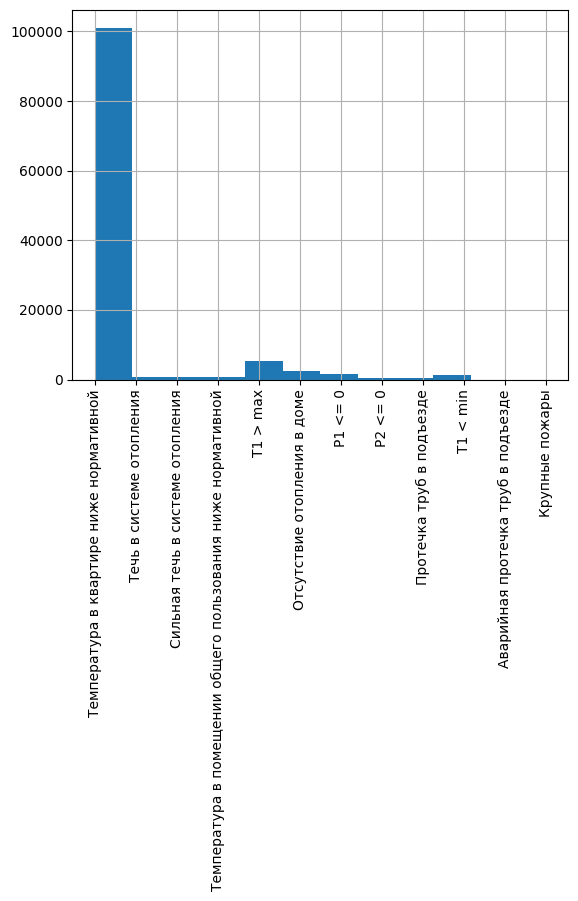

In [60]:
df_full[df_full.event.isin(target_events)].event.hist(xrot=90, bins=12);

In [173]:
len(df_full[df_full.event.isin(target_events)].unom.unique())

4340

In [171]:
len(df_full.unom.unique())

5115

# Признаки

## 9 Выгрузка по БТИ

- материал - стоит брать
- назначение/класс - при улучшении модели можно рассмотреть
- из адреса в теории может пригодиться округ или улица, если вдруг что-то поблизости ломалось

In [232]:
df9 = pd.read_excel("../raw/9. Выгрузка БТИ.xlsx", skiprows=1)

In [129]:
df9.head()

,Unnamed: 0,Город,Административный округ,Муниципальный округ,Населенный пункт,Улица,Тип номера дом,Номер дома,Номер корпуса,Тип номера строения/сооружения,Номер строения,Unnamed: 11,Unnamed: 12,Материал,Назначение,Класс,Тип,Этажность,Признак,Общая площадь
0,15,город Москва,Восточный административный округ,муниципальный округ Косино-Ухтомский,NaN,Златоустовская улица,дом,21,NaN,NaN,NaN,8450,1,NaN,NaN,жилые,Здание,NaN,NaN,NaN
1,17,город Москва,Восточный административный округ,муниципальный округ Косино-Ухтомский,NaN,Большая Косинская улица,дом,34В,NaN,NaN,NaN,51067,1,деревянные,индивидуальное жилое строение,жилые,Здание,1.0,NaN,"90,1"
2,18,город Москва,Восточный административный округ,муниципальный округ Ивановское,NaN,Зелёный проспект,дом,101,NaN,NaN,NaN,8425,1,NaN,NaN,жилые,Здание,NaN,NaN,NaN
3,19,город Москва,Восточный административный округ,муниципальный округ Ивановское,NaN,Зелёный проспект,дом,103,NaN,NaN,NaN,8426,1,NaN,NaN,жилые,Здание,NaN,NaN,NaN
4,53,город Москва,Восточный административный округ,муниципальный округ Косино-Ухтомский,NaN,улица Чёрное Озеро,дом,7,1,NaN,NaN,28680,1,NaN,NaN,жилые,Здание,NaN,NaN,NaN


In [235]:
df9.columns

Index(['Unnamed: 0', 'Город', 'Административный округ', 'Муниципальный округ',
       'Населенный пункт', 'Улица', 'Тип номера дом', 'Номер дома',
       'Номер корпуса', 'Тип номера строения/сооружения', 'Номер строения',
       'Unnamed: 11', 'Unnamed: 12', 'Материал', 'Назначение', 'Класс', 'Тип',
       'Этажность', 'Признак', 'Общая площадь'],
      dtype='object')

In [288]:
df9.Назначение.unique()

array([nan, 'индивидуальное жилое строение', 'многоквартирный дом',
       'жилое', 'жилой дом', 'общежитие', 'коттедж', 'интернат',
       'блокированный жилой дом', 'жилое строение', 'не определено',
       'комплекс многофункциональный', 'переход подземный',
       'спецназначение', 'станция общественного транспорта',
       'спальный корпус', 'спасательная станция', 'фильтры',
       'формовочный цех', 'фотолаборатория', 'химчистка',
       'хирургический корпус', 'хладоцентр', 'хлебозавод', 'хлораторная',
       'хозблок', 'трансформаторная подстанция',
       'хозяйственная постройка', 'хозяйственный корпус',
       'холодильная станция', 'холодильник', 'холодильный склад', 'храм',
       'хранилище', 'хранилище пленки', 'хранилище рентгенопленки',
       'центр обслуживания', 'центр реабилитации', 'церковь',
       'здание религиозных собраний', 'автостоянка открытого типа', 'цех',
       'цех бетоносмесительный', 'цех колбасный', 'цех кузнечный',
       'цех нестанд.оборуд.', '

In [287]:
df9 = df9[["Unnamed: 11", "Материал", "Назначение", "Класс"]]

In [289]:
df9.columns = ["unom", "material", "purpose", "class"]

In [134]:
df9

,unom,material
0,8450,NaN
1,51067,деревянные
2,8425,NaN
3,8426,NaN
4,28680,NaN
...,...,...
16560,5276478,NaN
16561,5246967,NaN
16562,5298941,NaN
16563,5298942,NaN


## 11. Выгрузка ОДПУ отопление

- на 4522 дома данные по отоплению с осени 2023 по январь 2024
- полезные данные могут быть по температурным показателям
- возможно, обработать как-то временной ряд
- есть ошибки, которые могут как-то пригодиться
- в .xlsx несколько таблиц, надо открыть все

In [271]:
df11 = pd.read_csv("../data/11_chauffage.csv")

In [214]:
len(df11.UNOM.unique())

4522

In [215]:
df11.columns

Index(['ID УУ', 'ID ТУ', 'Округ', 'Район', 'Потребители', 'Группа', 'UNOM',
       'Адрес', 'Центральное отопление(контур)', 'Марка счетчика ',
       'Серия/Номер счетчика', 'Дата', 'Месяц/Год', 'Unit',
       'Объём поданого теплоносителя в систему ЦО',
       'Объём обратного теплоносителя из системы ЦО',
       'Разница между подачей и обраткой(Подмес)',
       'Разница между подачей и обраткой(Утечка)', 'Температура подачи',
       'Температура обратки', 'Наработка часов счётчика',
       'Расход тепловой энергии ', 'Ошибки'],
      dtype='object')

In [272]:
df11 = df11[["UNOM", "Район", "Месяц/Год", "Объём поданого теплоносителя в систему ЦО", "Объём обратного теплоносителя из системы ЦО",
      "Разница между подачей и обраткой(Подмес)", "Разница между подачей и обраткой(Утечка)", "Температура подачи",
      "Температура обратки", "Наработка часов счётчика", "Расход тепловой энергии ", "Ошибки"]]

In [273]:
df11.Район.unique()

array(['Новокосино', 'Перово', 'Северное Измайлово', 'Измайлово',
       'Богородское', 'Сокольники', 'Соколиная Гора', 'Преображенское',
       'Восточный', 'Косино-Ухтомский', 'Гольяново', 'Ивановское',
       'Восточное Измайлово', 'Вешняки', 'Метрогородок', 'Новогиреево'],
      dtype=object)

## 6. плановые-внеплановые отключения

- может пригодиться причина
- в будущем, могут пригодиться даты

In [163]:
df6 = pd.read_csv("../data/6_plan_noplan_disconnections.csv")

In [250]:
df6.Причина.value_counts()

Причина
Установка приборов КИПиА       22
Снятие приборов учета          19
Замена запорной арматуры       19
Замена регулятора              17
Установка приборов учета       16
Ремонт ВВП                      7
Ремонт запорной арматуры        7
Определение утечки              5
Ремонт участка трубопровода     3
Name: count, dtype: int64

In [165]:
df6 = df6[["УНОМ", "Причина", "Фактическая дата включения", "Фактическая дата отключения"]]

In [166]:
df6

,УНОМ,Причина,Фактическая дата включения,Фактическая дата отключения
0,28396,Установка приборов КИПиА,2023-11-14 16:00:00.000000,2023-11-14 12:00:00.000000
1,28399,Установка приборов КИПиА,2023-11-14 16:00:00.000000,2023-11-14 12:00:00.000000
2,28400,Установка приборов КИПиА,2023-11-14 16:00:00.000000,2023-11-14 12:00:00.000000
3,2404752,Установка приборов учета,2023-11-30 15:00:00.000000,2023-11-30 13:00:00.000000
4,18228,Установка приборов учета,2023-11-30 15:00:00.000000,2023-11-30 13:00:00.000000
...,...,...,...,...
110,18046,Замена запорной арматуры,2024-04-26 16:00:00.000000,2024-04-26 12:00:00.000000
111,18039,Замена запорной арматуры,2024-04-26 16:00:00.000000,2024-04-26 12:00:00.000000
112,18045,Замена запорной арматуры,2024-04-26 16:00:00.000000,2024-04-26 12:00:00.000000
113,18040,Замена запорной арматуры,2024-04-26 16:00:00.000000,2024-04-26 12:00:00.000000


## 8

In [207]:
df8 = pd.read_csv("../data/8_data_asupr.csv")

In [208]:
df8.head()

,ID УУ,Адрес,Полный адрес,Округ,UNOM,Группа,№ ОДС,Адрес ОДС,Потребитель (или УК),ЦТП
0,785480981,"10-я Парковая ул., д. 15","город Москва, 10-я Парковая улица, дом 15",ВАО,18777,МКД,ОДС №27-Измайлово,"город Москва, 7-я Парковая улица, дом 15, корп...","ГБУ ""ЖИЛИЩНИК РАЙОНА ИЗМАЙЛОВО""",04-05-0604/185
1,785481133,"10-я Парковая ул., д. 17","город Москва, 10-я Парковая улица, дом 17",ВАО,18778,МКД,ОДС №27-Измайлово,"город Москва, 7-я Парковая улица, дом 15, корп...","ГБУ ""ЖИЛИЩНИК РАЙОНА ИЗМАЙЛОВО""",04-05-0604/185
2,1881452,"10-я Парковая ул., д. 18А","город Москва, 10-я Парковая улица, дом 18А",ВАО,2105327,Бюджет,NaN,NaN,ГКУ ДИРЕКЦИЯ ДОНМ,04-05-0604/124
3,785481250,"10-я Парковая ул., д. 4","город Москва, 10-я Парковая улица, дом 4",ВАО,18773,МКД,ОДС №57-Измайлово,"город Москва, 9-я Парковая улица, дом 27","ГБУ ""ЖИЛИЩНИК РАЙОНА ИЗМАЙЛОВО""",04-05-0604/064
4,785481200,"10-я Парковая ул., д. 6","город Москва, 10-я Парковая улица, дом 6",ВАО,18775,МКД,ОДС №57-Измайлово,"город Москва, 9-я Парковая улица, дом 27","ГБУ ""ЖИЛИЩНИК РАЙОНА ИЗМАЙЛОВО""",04-05-0604/064


# Prepare initial dataset with features

In [281]:
df_autumn = pd.read_csv("../data/events_autumn/events.csv", delimiter=';')
df_spring = pd.read_csv("../data/events_spring/events.csv", delimiter=';')
# rename columns to easily access them
df_autumn.columns = ["event", "source", "date_registry", "date_close", "district", "unom", "address", "datetime_finish_event"]
df_spring.columns = ["event", "source", "date_registry", "date_close", "district", "unom", "address", "datetime_finish_event"]
df_full = pd.concat([df_autumn, df_spring])

In [282]:
df_full["date_registry"] = pd.to_datetime(df_full["date_registry"]).dt.date
df_full["date_close"] = pd.to_datetime(df_full["date_close"]).dt.date

In [283]:
df_full = df_full[df_full.event.isin(target_events)].drop(columns=["district", "address", "source", "datetime_finish_event"])

In [286]:
df9.head()

,Unnamed: 0,Город,Административный округ,Муниципальный округ,Населенный пункт,Улица,Тип номера дом,Номер дома,Номер корпуса,Тип номера строения/сооружения,Номер строения,Unnamed: 11,Unnamed: 12,Материал,Назначение,Класс,Тип,Этажность,Признак,Общая площадь
0,15,город Москва,Восточный административный округ,муниципальный округ Косино-Ухтомский,NaN,Златоустовская улица,дом,21,NaN,NaN,NaN,8450,1,NaN,NaN,жилые,Здание,NaN,NaN,NaN
1,17,город Москва,Восточный административный округ,муниципальный округ Косино-Ухтомский,NaN,Большая Косинская улица,дом,34В,NaN,NaN,NaN,51067,1,деревянные,индивидуальное жилое строение,жилые,Здание,1.0,NaN,"90,1"
2,18,город Москва,Восточный административный округ,муниципальный округ Ивановское,NaN,Зелёный проспект,дом,101,NaN,NaN,NaN,8425,1,NaN,NaN,жилые,Здание,NaN,NaN,NaN
3,19,город Москва,Восточный административный округ,муниципальный округ Ивановское,NaN,Зелёный проспект,дом,103,NaN,NaN,NaN,8426,1,NaN,NaN,жилые,Здание,NaN,NaN,NaN
4,53,город Москва,Восточный административный округ,муниципальный округ Косино-Ухтомский,NaN,улица Чёрное Озеро,дом,7,1,NaN,NaN,28680,1,NaN,NaN,жилые,Здание,NaN,NaN,NaN


In [290]:
df_full = pd.merge(df_full, df9, how="left")
df_full = df_full.merge(df11_district, how="left")

In [277]:
df11_district = df11[["UNOM", "Район"]].drop_duplicates()

In [278]:
df11_district.columns = ["unom", "district"]

In [291]:
df_full

,event,date_registry,date_close,unom,material,purpose,class,district
0,Температура в квартире ниже нормативной,2023-10-08,2023-10-08,8171.0,кирпичные,многоквартирный дом,жилые,Преображенское
1,Температура в квартире ниже нормативной,2023-10-08,2023-10-08,8171.0,кирпичные,многоквартирный дом,жилые,Преображенское
2,Температура в квартире ниже нормативной,2023-10-09,2023-10-09,8171.0,кирпичные,многоквартирный дом,жилые,Преображенское
3,Температура в квартире ниже нормативной,2023-10-09,2023-10-09,8171.0,кирпичные,многоквартирный дом,жилые,Преображенское
4,Температура в квартире ниже нормативной,2023-10-27,2023-10-27,8171.0,кирпичные,многоквартирный дом,жилые,Преображенское


In [256]:
df_full["unom"] = df_full["unom"].astype("int")

In [262]:
np.round(df_full.event.value_counts() / df_full.event.value_counts().sum() * 100, 2)

event
Температура в квартире ниже нормативной                        88.23
T1 > max                                                        4.62
Отсутствие отопления в доме                                     2.12
P1 <= 0                                                         1.32
T1 < min                                                        1.26
Сильная течь в системе отопления                                0.61
Температура в помещении общего пользования ниже нормативной     0.59
Течь в системе отопления                                        0.53
P2 <= 0                                                         0.44
Протечка труб в подъезде                                        0.27
Аварийная протечка труб в подъезде                              0.00
Крупные пожары                                                  0.00
Name: count, dtype: float64

In [292]:
def events_with_filters(df, district):
    filter_df = df[df["district"] == district]
    
    event_distribution = np.round(filter_df.event.value_counts() / filter_df.event.value_counts().sum() * 100, 2)
    
    return event_distribution

In [294]:
df_full.district.unique()

array(['Преображенское', 'Измайлово', nan, 'Богородское', 'Новогиреево',
       'Перово', 'Метрогородок', 'Восточное Измайлово', 'Ивановское',
       'Вешняки', 'Гольяново', 'Северное Измайлово', 'Соколиная Гора',
       'Сокольники', 'Косино-Ухтомский', 'Новокосино', 'Восточный'],
      dtype=object)

In [297]:
events_with_filters(df_full, "Новогиреево")

event
Температура в квартире ниже нормативной                        92.98
T1 > max                                                        2.74
Отсутствие отопления в доме                                     1.71
T1 < min                                                        1.21
Сильная течь в системе отопления                                0.42
Течь в системе отопления                                        0.37
Температура в помещении общего пользования ниже нормативной     0.34
Протечка труб в подъезде                                        0.22
P1 <= 0                                                         0.01
Аварийная протечка труб в подъезде                              0.01
Name: count, dtype: float64